# Tea bag index (TBI) and decomposition kinetics in cranberry agroecosystems

*Wilfried Dossou-Yovo, Serge Étienne Parent,Noura Ziadi, Élizabeth Parent and Léon Étienne Parent*

In [36]:
print(Sys.Date())

[1] "2020-02-10"


## Objective

This notebook generates the results included in the manuscript *Tea bag index (TBI) and decomposition kinetics in cranberry agroecosystems*. The data set from 2017 trial is a collection of incubated tea bag weight, nitrogen, carbon and sulfur content, nitrogen type and doses on trials fieds. The aims of this study were to measure the TBI and kinetics of plant residue decomposition to estimate soil sequestration capacity in cranberry stands of Eastern Canada.

## Packages

We need package [tidyverse](https://www.tidyverse.org/) which loads a set of packages for easy data manipulation(Ex: [dplyr](https://www.rdocumentation.org/packages/dplyr/versions/0.7.8)) and visualization (ex: [ggplot2](https://www.rdocumentation.org/packages/ggplot2/versions/3.2.1)). A set of other packages is used: [readxl](https://www.rdocumentation.org/packages/readxl/versions/0.1.1) for importing xlsx files, [nlme](https://www.rdocumentation.org/packages/nlme/versions/3.1-143/topics/nlme) for fitting a nonlinear mixed-effects model, [e1071](https://www.rdocumentation.org/packages/e1071/versions/1.7-3) for latent class analysis.

In [38]:
library("tidyverse")
library("nlme")
#library("Metrics") # pour calculer le R²
library("e1071")

Warning message:
"package 'e1071' was built under R version 3.6.2"

Some custom functions.

In [39]:
pseudoR2 <- function(y, y_hat) {
  1 - (sum((y - y_hat)^2) / sum((y - mean(y))^2))
}

# Residuals
residues <- function(model, level = 0, computeResidues = TRUE, residues,
                   main = "") {
  library(e1071)
  if (computeResidues) {
    r = residuals(model, type="normalized", level)
  } else {
    r = residues
  }
  hist(r, freq=F, main = main, breaks=20)
  xfit<-seq(min(r),max(r),length=40)
  yfit<-dnorm(xfit)
  lines(xfit, yfit, col="red", lwd=2)
  print("Shapiro-Wilk:")
  print(shapiro.test(r))
  print(paste("Kurtosis:", kurtosis(r)))
  print(paste("Skewness:", skewness(r)))
}


## Import data

In [40]:
df <- read_csv("data/data__.csv")

Parsed with column specification:
cols(
  No = col_double(),
  `Tea type abbr` = col_character(),
  `Tea type` = col_character(),
  `Initial tea weight (g)` = col_double(),
  `Initial total weight (g)` = col_double(),
  `Initial bag weight (g)` = col_double(),
  `Remaining tea weight (g)` = col_double(),
  Farm = col_character(),
  Site = col_character(),
  `Farming system` = col_character(),
  `Nitrogen type` = col_character(),
  `Nitrogen dose` = col_double(),
  Repetition = col_double(),
  `Remaining C (%)` = col_double(),
  `Remaining N (%)` = col_double(),
  `Remaining S (%)` = col_double(),
  `Initial C fraction` = col_double()
)


Label repetitions in such a way they are unique per field and dose

In [41]:
df$`Dose repetition` = paste0(df$`Nitrogen dose`, '_', df$Repetition,'_', df$Site)

The *Cranberry litter* category will be used for the reference category in modeling.

In [42]:
df$`Tea type` = relevel(factor(df$`Tea type`), ref = 'Cranberry litter')

## Preprocess : weight loss rate

Weight loss rate has been estimate by

$$k_1 = \frac{-ln \left( \frac{M(t)}{M_0} \right) }{t}$$

Where $M_0$ is initial litter organic mass, $M(t)$ is litter organic mass that remains after incubation time $t = 90~days$, and $k_1$ is decomposition rate. 

In [43]:
kinetics_1st <- function(rw, iw, t) {
    -log(rw/iw)/t
}

In [44]:
df$k1 <- kinetics_1st(rw = df$`Remaining tea weight (g)`,
                      iw = df$`Initial tea weight (g)`,
                      t = 90)

## Data exploration

In [45]:
head(df)

No,Tea type abbr,Tea type,Initial tea weight (g),Initial total weight (g),Initial bag weight (g),Remaining tea weight (g),Farm,Site,Farming system,Nitrogen type,Nitrogen dose,Repetition,Remaining C (%),Remaining N (%),Remaining S (%),Initial C fraction,Dose repetition,k1
1,G,Green tea,1.793,2.019,0.226,0.783,Belanger,A9,Organic,N-8-0-0,0,1,50.144,5.2809,0.290,0.8605444,0_1_A9,0.009205698
2,G,Green tea,1.786,2.011,0.225,0.797,Belanger,A9,Organic,N-8-0-0,0,1,50.933,4.4082,0.251,0.8571847,0_1_A9,0.008965323
3,G,Green tea,1.782,2.008,0.228,NA,Belanger,A9,Organic,N-8-0-0,0,1,NA,NA,NA,0.8552650,0_1_A9,NA
4,G,Green tea,1.760,1.987,0.227,0.778,Belanger,A9,Organic,N-8-0-0,0,2,50.292,5.4397,0.296,0.8447061,0_2_A9,0.009070473
5,G,Green tea,1.788,2.013,0.226,0.779,Belanger,A9,Organic,N-8-0-0,0,2,47.718,4.8735,0.277,0.8581446,0_2_A9,0.009231577
6,G,Green tea,1.779,2.004,0.227,NA,Belanger,A9,Organic,N-8-0-0,0,2,NA,NA,NA,0.8538251,0_2_A9,NA


Boxplot

Warning message:
"Removed 49 rows containing non-finite values (stat_boxplot)."

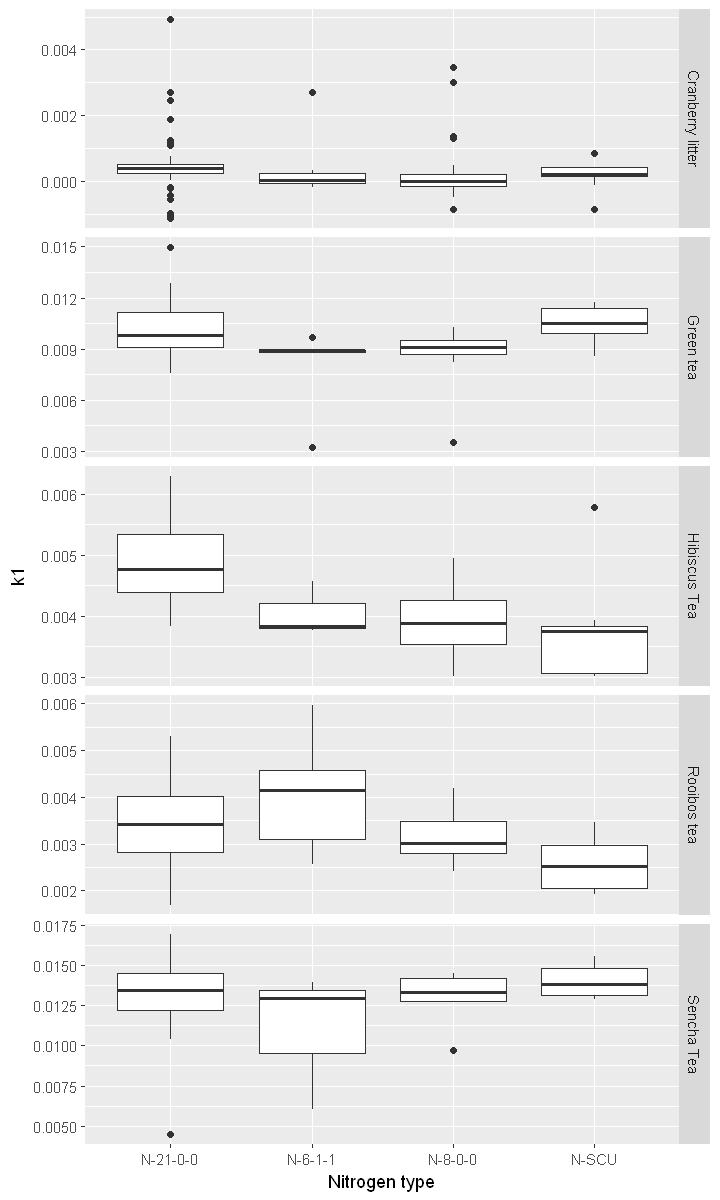

In [46]:
options(repr.plot.width=6, repr.plot.height=10)
ggplot(data = df,
       mapping = aes(x = `Nitrogen type`, y = k1)) +
  facet_grid(`Tea type` ~ ., scales = "free") +
  geom_boxplot()

## What's affecting litters weight?

### Mixed model

In [47]:
df <- df %>%
  mutate(`Nitrogen dose scaled` = scale(`Nitrogen dose`))

In [48]:
df_mm <- df %>%
  rename(tea = `Tea type`,
         Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose scaled`) %>%
  mutate(tea = factor(tea),
         Ntype = factor(Ntype)) %>%
  drop_na() %>%
  droplevels()

In [49]:
k1_mm <- lme(fixed = k1 ~ Ntype + Ndose * tea,
                     random = ~ 1 | Farm/Site,
                     data = df_mm)

In [50]:
anova(k1_mm)

,numDF,denDF,F-value,p-value
(Intercept),1,346,90.4235185,0.000000e+00
Ntype,3,346,9.2425070,6.769315e-06
Ndose,1,346,0.4951898,4.820946e-01
tea,4,346,1309.7307309,0.000000e+00
Ndose:tea,4,346,2.4427939,4.649410e-02


In [51]:
pseudoR2(y = df_mm$k1,
         y_hat = predict(k1_mm, level = 0))

[1] 0.9179982

[1] "Shapiro-Wilk:"

	Shapiro-Wilk normality test

data:  r
W = 0.93463, p-value = 1.636e-11

[1] "Kurtosis: 4.72506311595992"
[1] "Skewness: 0.0203648806888307"


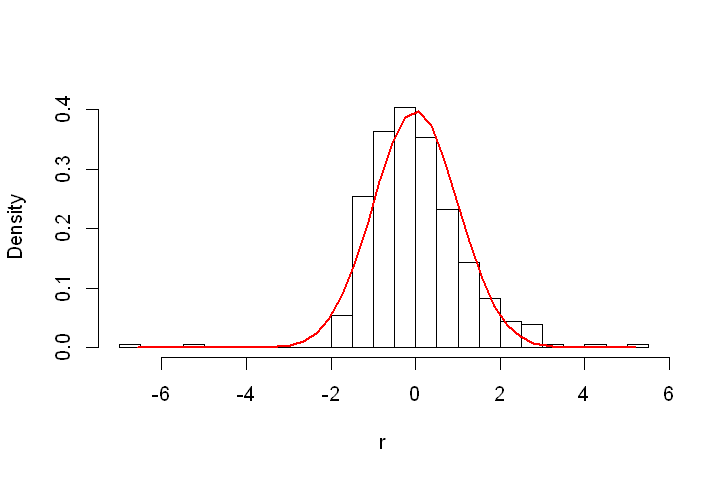

In [52]:
options(repr.plot.width=6, repr.plot.height=4)
residues(k1_mm)

In [53]:
k1_gg <- data.frame(intervals(k1_mm, which = "fixed")$fixed)
k1_gg <- k1_gg %>%
  mutate(variable = rownames(k1_gg))
k1_gg <- k1_gg %>%
  mutate(pvalue = summary(k1_mm)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

Ajust names.

In [54]:
k1_gg$variable <- c("Intercept", "N 6-1-1", "N 8-0-0", "N SCU-39-0-0",
                    "Dose N (scaled)", "Green tea", "Hibiscus tea", "Rooibos tea", "Sencha tea",
                     "Green tea : Dose N", "Hibiscus tea : Dose N", "Rooibos tea : Dose N", "Sencha tea : Dose N")

Add random effects to the table.

In [55]:
k1_re <- data.frame(matrix(ncol = ncol(k1_gg), nrow = 6))
names(k1_re) <- names(k1_gg)
k1_re$est. <- c(ranef(k1_mm)$Farm[, 1], ranef(k1_mm)$Site[, 1])
k1_re$variable <- c(rownames(ranef(k1_mm)$Farm),
                    rownames(ranef(k1_mm)$Site))

In [56]:
if (!("Belanger" %in% k1_gg$variable)) k1_gg <- bind_rows(k1_gg, k1_re) # with an if to make sure ranefs are stacked only once

Create a facet column to separate effects by effect category in the plot.

In [57]:
k1_gg$facet <- factor(c('Intercept',
                        'N source', 'N source', 'N source',
                        "N dosage",
                        'Tea type', 'Tea type', 'Tea type', 'Tea type',
                        'Tea type x N dosage', 'Tea type x N dosage', 
                        'Tea type x N dosage', 'Tea type x N dosage',
                        "Random effect", "Random effect", "Random effect", "Random effect", "Random effect", "Random effect"))

In [ ]:
k1_gg <- k1_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", "Tea type x N dosage", "Tea type", "N dosage", "N source"))))

In [ ]:
options(repr.plot.width=12, repr.plot.height=6)

k1_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20)) +
  ggsave("Figure2.png", width = 8, height = 5, dpi = 600)

In [ ]:
pred_grid <- expand.grid(tea = unique(df_mm$tea),
                                     Ndose = c(-2, 2),
                                     Ntype = unique(df_mm$Ntype))
pred_grid <- pred_grid %>%
  mutate(k1 = predict(k1_mm, newdata = pred_grid,
                              level = 0),
         Ndose = Ndose * sd(df$`Nitrogen dose`) + mean(df$`Nitrogen dose`)) %>%
  rename(`Tea type` = tea,
         `Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype)

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)

ggplot(df, aes(x = `Nitrogen dose`, y = `k1`)) +
  facet_grid(`Nitrogen type` ~ `Tea type`) +
  geom_point() +
  geom_line(data = pred_grid) +
  labs(x = expression("Dose N (kg ha"^"-1"~")"), y = "First order kinetics") +
  theme_bw() +
  theme(text = element_text(size = 20)) + # strip.text.y = element_text(angle=0)
  ggsave("figures/k1-model-lines.png", width = 10, height = 6, dpi = 600)# nomme figure

## Tea bag index

In [ ]:
head(Data_1)

In [ ]:
df <- df %>%
  mutate(`M / M0` = `Remaining tea weight (g)` / `Initial tea weight (g)`)

Hydrolysable fraction 

In [ ]:
Hf_g = 0.805 
Hf_r = 0.826

Keuskamp hydrolysable fraction

In [ ]:
#Hf_g = 0.842
#Hf_r = 0.552

In [ ]:
df <- df %>%
  mutate(a = ifelse(`Tea type` == "Green tea",
                    (`Initial tea weight (g)` - `Remaining tea weight (g)`) / `Initial tea weight (g)`,
                    NA),
         S = 1 - a / Hf_g)

In [ ]:
df <- df %>%
  mutate(sdr = paste(df$Site, df$`Nitrogen dose`, df$Repetition))
sdr_u <- unique(df$sdr)

Compute litter stability (Green tea) and decomposition constant (Roibos) for each experimental unit.

In [ ]:
for (i in 1:length(sdr_u)) {
  # Green tea
  Sg_i <- mean(df$S[df$sdr == sdr_u[i] & df$`Tea type` == "Green tea"], na.rm = TRUE)
  
  # Rooibos
  df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- Hf_r * (1 - Sg_i)
  ar_i <- df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  M_M0i <- df$`M / M0`[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  df$k_tbi[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- log(ar_i / (M_M0i - (1-ar_i))) / 90
}

In [ ]:
df_rooibos <- df %>%
  filter(`Tea type` == "Rooibos tea")

In [ ]:
head(df_rooibos)

Data exploration for N dose type.

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): objet 'k_tbi' introuvable

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(c

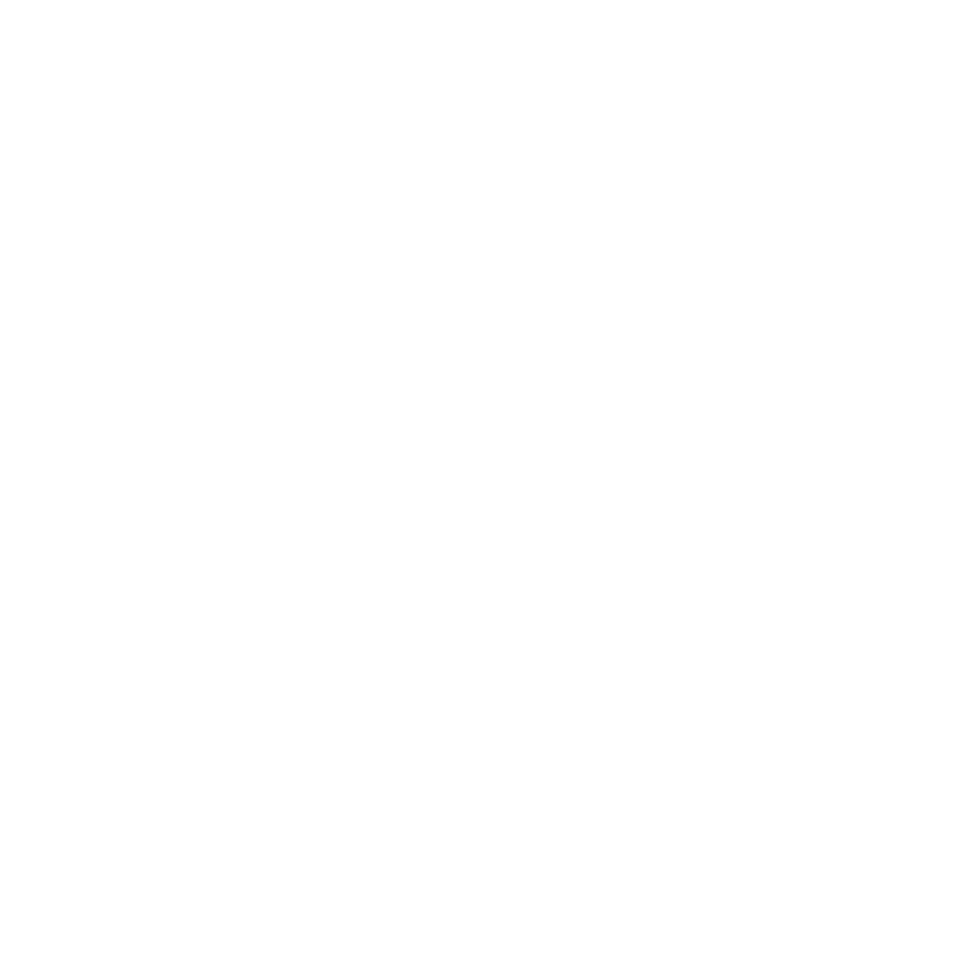

In [17]:
options(repr.plot.width=8, repr.plot.height=8)
ggplot(data = df,
       mapping = aes(x = `Nitrogen type`, y = k_tbi)) +
  facet_grid(`Nitrogen dose` ~ .) +
  geom_boxplot()

### What affecting TBI parameters (k)?

In [18]:
TBI_data <- df %>%
  select(k_tbi, `Tea type`, Farm, `Nitrogen dose`, Site,
         `Nitrogen type`) %>%
  rename(Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose`) %>%
  drop_na() %>%
  droplevels()

ERROR: Error in .f(.x[[i]], ...): objet 'k_tbi' introuvable


In [ ]:
TBI_rooibos <- TBI_data %>%
  filter(`Tea type` == "Rooibos tea")

In [ ]:
lme_TBI <- lme(fixed = k_tbi ~  Ndose + Ntype,
    random = ~ 1 | Farm/Site,
    data = TBI_rooibos) # [omdecomp_data$TauxDecomposition_C > 0, ]

In [ ]:
pred_grid_tbi <- expand.grid(Ndose = c(0, 60),
                             Ntype = unique(df_mm$Ntype))
pred_grid_tbi <- pred_grid_tbi %>%
  mutate(k_tbi = predict(lme_TBI, newdata = pred_grid_tbi,
                              level = 0)) %>%
  rename(`Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype)

In [ ]:
pred_grid_tbi

In [ ]:
options(repr.plot.width=10, repr.plot.height=10)

TBI_rooibos %>% 
  rename(`Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype) %>%
  ggplot(aes(x = `Nitrogen dose`, y = k_tbi)) +
  facet_grid(`Nitrogen type` ~ .) +
  geom_point() +
  geom_line(data = pred_grid_tbi) +
  labs(x = expression("Dose N (kg ha"^"-1"~")"), y = "Tea bag index kinetics") +
  theme_bw() +
  theme(text = element_text(size = 20),
        strip.text.y = element_text(angle=0)) +
  ggsave("figures/tbi-model-lines.png", width = 10, height = 6, dpi = 600)# nomme figure

In [19]:
ktbi_gg <- data.frame(intervals(lme_TBI, which = "fixed")$fixed)
ktbi_gg <- ktbi_gg %>%
  mutate(variable = rownames(ktbi_gg))
ktbi_gg <- ktbi_gg %>%
  mutate(pvalue = summary(lme_TBI)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

ERROR: Error in intervals(lme_TBI, which = "fixed"): objet 'lme_TBI' introuvable


Ajust names.

In [20]:
ktbi_gg$variable <- c("Intercept", "Dose N", "N 6-1-1", "N 8-0-0", "N SCU-39-0-0")

ERROR: Error in ktbi_gg$variable <- c("Intercept", "Dose N", "N 6-1-1", "N 8-0-0", : objet 'ktbi_gg' introuvable


Add random effects to the table.

In [21]:
ktbi_re <- data.frame(matrix(ncol = ncol(ktbi_gg), nrow = 6))
names(ktbi_re) <- names(ktbi_gg)
ktbi_re$est. <- c(ranef(lme_TBI)$Farm[, 1], ranef(lme_TBI)$Site[, 1])
ktbi_re$variable <- c(rownames(ranef(lme_TBI)$Farm),
                    rownames(ranef(lme_TBI)$Site))

ERROR: Error in ncol(ktbi_gg): objet 'ktbi_gg' introuvable


In [ ]:
if (!("Belanger" %in% ktbi_gg$variable)) ktbi_gg <- bind_rows(ktbi_gg, ktbi_re) # with an if to make sure ranefs are stacked only once

Create a facet column to separate effects by effect category in the plot.

In [22]:
ktbi_gg$facet <- factor(c('Intercept',
                        "N dosage",
                        'N source', 'N source', 'N source',
                        "Random effect", "Random effect", "Random effect", "Random effect", "Random effect", "Random effect"))

ERROR: Error in ktbi_gg$facet <- factor(c("Intercept", "N dosage", "N source", : objet 'ktbi_gg' introuvable


In [ ]:
ktbi_gg <- ktbi_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", "N dosage", "N source", "Intercept"))))

In [23]:
options(repr.plot.width=12, repr.plot.height=6)

ktbi_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20)) +
  ggsave("ktbi-lme-effects.png", width = 8, height = 5, dpi = 600)

ERROR: Error in eval(lhs, parent, parent): objet 'ktbi_gg' introuvable


### What affecting TBI parameters (S)?

In [24]:
S_data <- df %>%
  select(S, `Tea type`, Farm, `Nitrogen dose`, Site,
         `Nitrogen type`) %>%
  rename(Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose`) %>%
  drop_na() %>%
  droplevels()

ERROR: Error in .f(.x[[i]], ...): objet 'S' introuvable


In [ ]:
S_greentea <- S_data %>%
  filter(`Tea type` == "Green tea")

In [25]:
lme_S <- lme(fixed = S ~  Ndose + Ntype,
    random = ~ 1 | Farm/Site,
    data = S_greentea)

ERROR: Error in is.data.frame(data): objet 'S_greentea' introuvable


In [ ]:
pred_grid_S <- expand.grid(Ndose = c(0, 60),
                           Ntype = unique(df_mm$Ntype))
pred_grid_S <- pred_grid_S %>%
  mutate(S = predict(lme_S, newdata = pred_grid_S,
                              level = 0)) %>%
  rename(`Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype)

In [26]:
options(repr.plot.width=10, repr.plot.height=10)

S_greentea %>% 
  rename(`Nitrogen dose` = Ndose,
         `Nitrogen type` = Ntype) %>%
  ggplot(aes(x = `Nitrogen dose`, y = S)) +
  facet_grid(`Nitrogen type` ~ .) +
  geom_point() +
  geom_line(data = pred_grid_S) +
  labs(x = expression("Dose N (kg ha"^"-1"~")"), y = "Tea bag stability index") +
  theme_bw() +
  theme(text = element_text(size = 20),
        strip.text.y = element_text(angle=0)) +
  ggsave("figures/S-model-lines.png", width = 10, height = 6, dpi = 600)# nomme figure

ERROR: Error in eval(lhs, parent, parent): objet 'S_greentea' introuvable


In [ ]:
S_gg <- data.frame(intervals(lme_S, which = "fixed")$fixed)
S_gg <- S_gg %>%
  mutate(variable = rownames(S_gg))
S_gg <- S_gg %>%
  mutate(pvalue = summary(lme_S)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

Ajust names.

In [27]:
S_gg$variable <- c("Intercept", "Dose N", "N 6-1-1", "N 8-0-0", "N SCU-39-0-0")

ERROR: Error in S_gg$variable <- c("Intercept", "Dose N", "N 6-1-1", "N 8-0-0", : objet 'S_gg' introuvable


Add random effects to the table.

In [28]:
S_re <- data.frame(matrix(ncol = ncol(S_gg), nrow = 6))
names(S_re) <- names(S_gg)
S_re$est. <- c(ranef(lme_S)$Farm[, 1], ranef(lme_S)$Site[, 1])
S_re$variable <- c(rownames(ranef(lme_S)$Farm),
                    rownames(ranef(lme_S)$Site))

ERROR: Error in ncol(S_gg): objet 'S_gg' introuvable


In [29]:
if (!("Belanger" %in% S_gg$variable)) S_gg <- bind_rows(S_gg, S_re) # with an if to make sure ranefs are stacked only once

ERROR: Error in "Belanger" %in% S_gg$variable: objet 'S_gg' introuvable


Create a facet column to separate effects by effect category in the plot.

In [30]:
S_gg$facet <- factor(c('Intercept',
                        "N dosage",
                        'N source', 'N source', 'N source',
                        "Random effect", "Random effect", "Random effect", "Random effect", "Random effect", "Random effect"))

ERROR: Error in S_gg$facet <- factor(c("Intercept", "N dosage", "N source", "N source", : objet 'S_gg' introuvable


In [31]:
S_gg <- S_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", "N dosage", "N source", "Intercept"))))

ERROR: Error in eval(lhs, parent, parent): objet 'S_gg' introuvable


In [32]:
options(repr.plot.width=12, repr.plot.height=6)

S_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 20)) +
  ggsave("S-lme-effects.png", width = 8, height = 5, dpi = 600)

ERROR: Error in eval(lhs, parent, parent): objet 'S_gg' introuvable


## Reproducing Keuskamp TBI

In [33]:
library("ggrepel")
df_keuskamp <- read_csv("data//keuskamp_tbi_data.csv")

Warning message:
"package 'ggrepel' was built under R version 3.6.2"Parsed with column specification:
cols(
  Nombre = col_double(),
  Region = col_character(),
  Stabilisation_factor_S = col_double(),
  Decomposition_rate_K = col_double()
)


In [34]:
df_keuskamp <- df_keuskamp %>%
  mutate(is_cranberry = Region == "Cranberries")

In [35]:
options(repr.plot.width=6.5, repr.plot.height=6)
ggplot(data = df_keuskamp, aes(x = Stabilisation_factor_S, y = Decomposition_rate_K)) +
  geom_point() +
  geom_label_repel(aes(label = Region, fill = is_cranberry, colour = is_cranberry),
                   size = 3.5) +
  scale_fill_manual(values = c("white", "black")) +
  scale_colour_manual(values = c("black", "white")) +
  theme_bw() +
  theme(legend.position = "none") +
  labs(x = "Stabilization factor (S)", y = "Decomposition rate (k1)") +
  ggsave("images/TBI-keuskamp.png", width = 6, height = 6, dpi = 120)

Warning message in grDevices::png(..., res = dpi, units = "in"):
"impossible d'ouvrir le fichier 'images/TBI-keuskamp.png' pour écriture"Warning message in grDevices::png(..., res = dpi, units = "in"):
"opening device failed"

ERROR: Error in grDevices::png(..., res = dpi, units = "in"): impossible de démarrer le périphérique png()
